**Setup**

In [16]:
# Module Imports
from openai import OpenAI
import os, docx, pdfplumber, subprocess

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage # User Input and System Prompt

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [2]:
# Load .env File
%load_ext dotenv
%dotenv

In [3]:
# OpenAI API & Key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
llm = ChatOpenAI(model="gpt-4o")

*Tools*

In [4]:
# Tool to Extract CV
@tool 
def extract_cv_text(file_path: str) -> str:
    """
        Extracts the text components from a CV file in PDF, DocX, or DOC format. The CV should be inside the
        same folder that this notebook is in. 

        Args:
            file_path (str): The local file path to the CV Document.

        Returns:
            str: The extracted plain text from the CV, or an error message if the format is unsupported or cannot be read. 
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ".docx" in ext:
        try:
            doc = docx.Document(file_path)
            text = [para.text for para in doc.paragraphs] 
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .doc file: {e}"

    elif ".pdf" in ext:
        try:
            text = []
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text.append(page_text)
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .pdf file: {e}"

    elif ".doc" in ext:
        try:
            temp_docx = file_path + ".temp.docx"
            subprocess.run(['soffice','--headless','--convert-to', 'docx', '--outdir', os.path.dirname(file_path), file_path],check=True)
            doc = docx.Document(os.path.splitext(file_path)[0] + '.docx')
            text = [para.text for para in doc.paragraphs]

            os.remove(os.path.splitext(file_path)[0]+".docx")
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading .doc file: {e}"

    else:
        return "Unsupported file format! Please use .pdf, .docx, or .doc."

In [5]:
# Tool to Webscrape Job Posting
@tool
def job_posting_tool(job_link: str) -> str:
    """
    Extracts structured information from a job posting at the provided URL.

    Args:
        job_link (str): The URL of the job posting

    Returns:
        str: A structured summary of the job posting's key details.
    """
    completion = client.chat.completions.create(
        model="gpt-4o-search-preview",
        web_search_options={"search_context_size": "medium"},
        messages=[
            {
                "role": "user",
                "content": """
                        You are a helpful tool that visits the following job post and carefully reads its content.
                        Summarize the key details in a clear and concise format, including:
                        Visit the provided job posting link, read it thoroughly, and extract and summarize all key information. Include:
                        - Job Title
                        - Company Name
                        - Location
                        - Employment Type (Full-time, part-time, contract, etc.)
                        - Salary or Compensation (if available) 
                        - Required Qualifications/Skills
                        - Primary Responsibilities
                        - Benefits Offered
                        - Application Instructions
                        - Posting Date (if available)
        
                        Format:
                        - Respond with a clear, structured bullet-point list
                        - Use exact factual information from the posting, no rewording beyond making it concise.
                        - If the posting is missing, inaccessible, or contains no job details, respond with:
                        "job posting unavailable or contains no job details." 
        
                        Do's
                        - Ensure all extracted details are accurate and directly taken from the posting 
                        - Keep description short, professional, and easy to scan
                        - Use consistent formatting for all fields (e.g., "Job title: ...")
                        Dont's
                        - Do not include filler language, speculation, or personal opinions
                        - Do not rewrite or interpret details-only report factual information from the posting
                        """,
            },
            {
                "role": "user",
                "content": f"visit this job posting and extract details:\n{job_link}",
            },
        ],
    )

    return completion.choices[0].message.content

*Binding Tools to LLM*

In [6]:
tools = [job_posting_tool, extract_cv_text]
tool_node = ToolNode(tools=tools)

In [7]:
llm_with_tools = llm.bind_tools(tools)

*Building out System Message*

In [8]:
sys_msg = SystemMessage(content="""
    You are an expert career assistant that helps the users with questions related to jobs, careers, and applications.

    Your Key Capabilities:
    - You have access to the user's CV and can read its contents using the 'extract_cv_text' tool
    - You can look up and extract details from job postings using the 'job_posting_tool'
    - You can compare the user's CV against one or more job posting to determine suitability and provide tailored advice
    - You can suggest improvements to the CV for better alignment with target roles. 

    When Answering:
    1. First, think step-by-step about the user's request.
    2. If the task requires reading the CV, call the CV extraction tool before answering
    3. If the task involves evaluating job postings, call the job posting tool to gather accurate information before answering
    4. Compare and reason about the information before providing your final response

    Response Format:
    - Be clear, concise, and structured with bullet points or numbered lists
    - Use section headers when possible (e.g., "Strengths", "Weaknesses", "Recommendations").
    - Support your statements with evidence from the CV or job postings.
    - Avoid vague language-be specific and factual

    Constraints:
    - Do not invent or guess details about the user's experience or job postings.
    - Only use information available in the CV, job postings, or provided content.
    - Keep your tone professional, friendly, and supportive 

    """)

In [9]:
# Inserts system message, then appends messages from current conversation, then return a single key with the model replies 
# Sends System Prompt + Conversation to the LLM, the LLM ingests it, then returns a new message
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

*Building a Graph System*

In [10]:
# Short Term Memory
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools)) # ToolNode acts as a Dispatcher for Tools 

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition) # Assistant can call the tools or end the conversation

builder.add_edge("tools", "assistant") 
react_graph = builder.compile()

*System Visual*

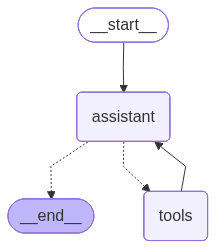

In [11]:
react_graph

*Adding Memory*

In [18]:
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

*Testing Graph*

In [19]:
messages = [
    HumanMessage(
        content="""
                Can you take a look at my CV (path: ./Documents/Garrett Audet - Resume.pdf) and these three job applications and tell me which is most suitable for my experience:
                
                1) https://ca.linkedin.com/jobs/view/canada-gtm-strategy-operations-lead-at-square-4286742601
                2) https://ca.linkedin.com/jobs/view/analyst-strategy-operations-at-scotiabank-4370606419
                3) https://ca.linkedin.com/jobs/view/head-of-business-transformation-at-rubicon-organics%E2%84%A2-4278758423
                """
        )
    ]

In [20]:
result = react_graph.invoke({"messages": messages}, config)

In [21]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


                Can you take a look at my CV (path: ./Documents/Garrett Audet - Resume.pdf) and these three job applications and tell me which is most suitable for my experience:

                1) https://ca.linkedin.com/jobs/view/canada-gtm-strategy-operations-lead-at-square-4286742601
                2) https://ca.linkedin.com/jobs/view/analyst-strategy-operations-at-scotiabank-4370606419
                3) https://ca.linkedin.com/jobs/view/head-of-business-transformation-at-rubicon-organics%E2%84%A2-4278758423
                
================================== Ai Message ==================================
Tool Calls:
  extract_cv_text (call_3TyWynrOWr9a6lqcy21nTQ5z)
 Call ID: call_3TyWynrOWr9a6lqcy21nTQ5z
  Args:
    file_path: ./Documents/Garrett Audet - Resume.pdf
  job_posting_tool (call_5CihdyhOUT33gI0z6lNnAWfl)
 Call ID: call_5CihdyhOUT33gI0z6lNnAWfl
  Args:
    job_link: https://ca.linkedin.c

*Short Term Memory Test*

In [22]:
messages = [
    HumanMessage(
        content="""
            For which job am i least suited?
        """
        )
    ]

result = react_graph_.invoke({"messages": messages}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


            For which job am i least suited?
        
================================== Ai Message ==================================

To determine which job you are least suited for, I will need to review your CV and the details of the job postings you're considering. Please provide the link to the job postings or specify the file path to your CV so I can assist you further.
